In [34]:
import pandas as pd
import numpy as np
import datetime
from time import ctime
import warnings
warnings.filterwarnings('ignore')

In [35]:
# Datos de entrenamiento limpios y con features agregados
train = pd.read_csv('../data/to_train_01.csv', low_memory=False, lineterminator='\n')

print(train.info())
train.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 94 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             260601 non-null  int64  
 1   damage_grade                            260601 non-null  int64  
 2   geo_level_1_id                          260601 non-null  int64  
 3   geo_level_2_id                          260601 non-null  int64  
 4   geo_level_3_id                          260601 non-null  int64  
 5   count_floors_pre_eq                     260601 non-null  int64  
 6   age                                     260601 non-null  int64  
 7   area_percentage                         260601 non-null  int64  
 8   height_percentage                       260601 non-null  int64  
 9   has_superstructure_adobe_mud            260601 non-null  bool   
 10  has_superstructure_mud_mortar_stone     2606

,building_id,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,...,plan_configuration_d,plan_configuration_u,plan_configuration_s,plan_configuration_q,plan_configuration_m,plan_configuration_c,plan_configuration_a,plan_configuration_n,plan_configuration_f,plan_configuration_o\r
0,802906,3,6,487,12198,2,30,6,5,True,...,1,0,0,0,0,0,0,0,0,0


In [36]:
# Datos de prueba
test = pd.read_csv('../data/to_test_01.csv', low_memory=False, lineterminator='\n')
print(test.info())
test.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 93 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   building_id                             86868 non-null  int64  
 1   geo_level_1_id                          86868 non-null  int64  
 2   geo_level_2_id                          86868 non-null  int64  
 3   geo_level_3_id                          86868 non-null  int64  
 4   count_floors_pre_eq                     86868 non-null  int64  
 5   age                                     86868 non-null  int64  
 6   area_percentage                         86868 non-null  int64  
 7   height_percentage                       86868 non-null  int64  
 8   has_superstructure_adobe_mud            86868 non-null  int64  
 9   has_superstructure_mud_mortar_stone     86868 non-null  int64  
 10  has_superstructure_stone_flag           86868 non-null  in

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura,cant_materiales\r
0,300051,17,596,11307,3,20,7,6,0,1,...,0.297767,1.166667,42,49,36,6.5,0.333333,0.142857,0.166667,1


## Entrenamiento del modelo

### Seleccion de features

In [37]:
def seleccion_de_features(df_train):
    '''
    Funcion para seleccionar features.
    features_to_remove es la base que contiene building_id y damage_grade
    Las demas listas, las creamos y las agregamos a subset_features para luego appendearlas a features_to_remove
    '''
    features_to_remove = ['building_id', 'damage_grade']
    subset_features = []
    has_secondary = [col for col in df_train.columns if 'has_secondary' in col]
    subset_features.append(has_secondary)
    legal_ownership = [col for col in df_train.columns if 'legal_ownership' in col]
    subset_features.append(legal_ownership)
    #plan_configuration = [col for col in df_train.columns if 'plan_configuration' in col]
    #subset_features.append(plan_configuration)
    #geo_level = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    #subset_features.append(geo_level)
    for subset in subset_features:
        features_to_remove += subset
    return features_to_remove

In [38]:
features_to_remove = seleccion_de_features(train)
Y = train['damage_grade']
X = train.drop(features_to_remove, axis=1)

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208480 entries, 230979 to 89754
Data columns (total 78 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   geo_level_1_id                          208480 non-null  int64  
 1   geo_level_2_id                          208480 non-null  int64  
 2   geo_level_3_id                          208480 non-null  int64  
 3   count_floors_pre_eq                     208480 non-null  int64  
 4   age                                     208480 non-null  int64  
 5   area_percentage                         208480 non-null  int64  
 6   height_percentage                       208480 non-null  int64  
 7   has_superstructure_adobe_mud            208480 non-null  bool   
 8   has_superstructure_mud_mortar_stone     208480 non-null  bool   
 9   has_superstructure_stone_flag           208480 non-null  bool   
 10  has_superstructure_cement_mortar_stone  

### Parameter tuning

> https://stackoverflow.com/questions/20463281/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn

> https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [41]:
# El mejor score de RandomForest con GridSearchCV fue: 0.7605
# Training Score: 0.8029
# Test Score:  0.7566
best_params = {
    'min_samples_split': 60, 
    'n_estimators': 500,
    'n_jobs':-1
}

params_search = {
    'n_estimators': [500],
    'min_samples_split':[60],
    'max_features':[None, 'log2', 'auto']
    'n_jobs':[-1],
    'max_depth': [20, 40, 60]
}


print('Hora antes de empezar a tunear/entrenar: {}'.format(ctime()))
#model = GridSearchCV(estimator = RandomForestClassifier(), param_grid=params_search, scoring='f1_micro', n_jobs=-1, cv=5, verbose=10)
model = RandomForestClassifier(**best_params)
model.fit(X_train, y_train)
print('Hora al finalizar de tunear/entrenar: {}'.format(ctime()))

Hora antes de empezar a tunear/entrenar: Thu Jul  8 00:24:48 2021
Hora al finalizar de tunear/entrenar: Thu Jul  8 00:26:18 2021


In [47]:
# Esto ejecutar solo cuando estemos haciendo GridSearchCV
print('El mejor score de RandomForest con GridSearchCV fue: {}'.format((model.best_score_).round(4)))
print('Mejor parametros hasta el momento: ')
model.best_params_

El mejor score de RandomForest con GridSearchCV fue: 0.7516
Mejor parametros hasta el momento: 


{'max_depth': 8, 'min_samples_split': 60, 'n_estimators': 500, 'n_jobs': -1}

In [44]:
from sklearn.metrics import f1_score

# Vemos el score comprobando contra el set de test y de train
model_f1_micro_test = f1_score(y_test, y_pred_test, average='micro')
y_pred_train = model.predict(X_train)
model_f1_micro_train = f1_score(y_train, y_pred_train, average='micro')
print("Training Score: %.4f" % model_f1_micro_train)
print("Test Score:  %.4f" % model_f1_micro_test)

Training Score: 0.8029
Test Score:  0.7566


### Feature importance

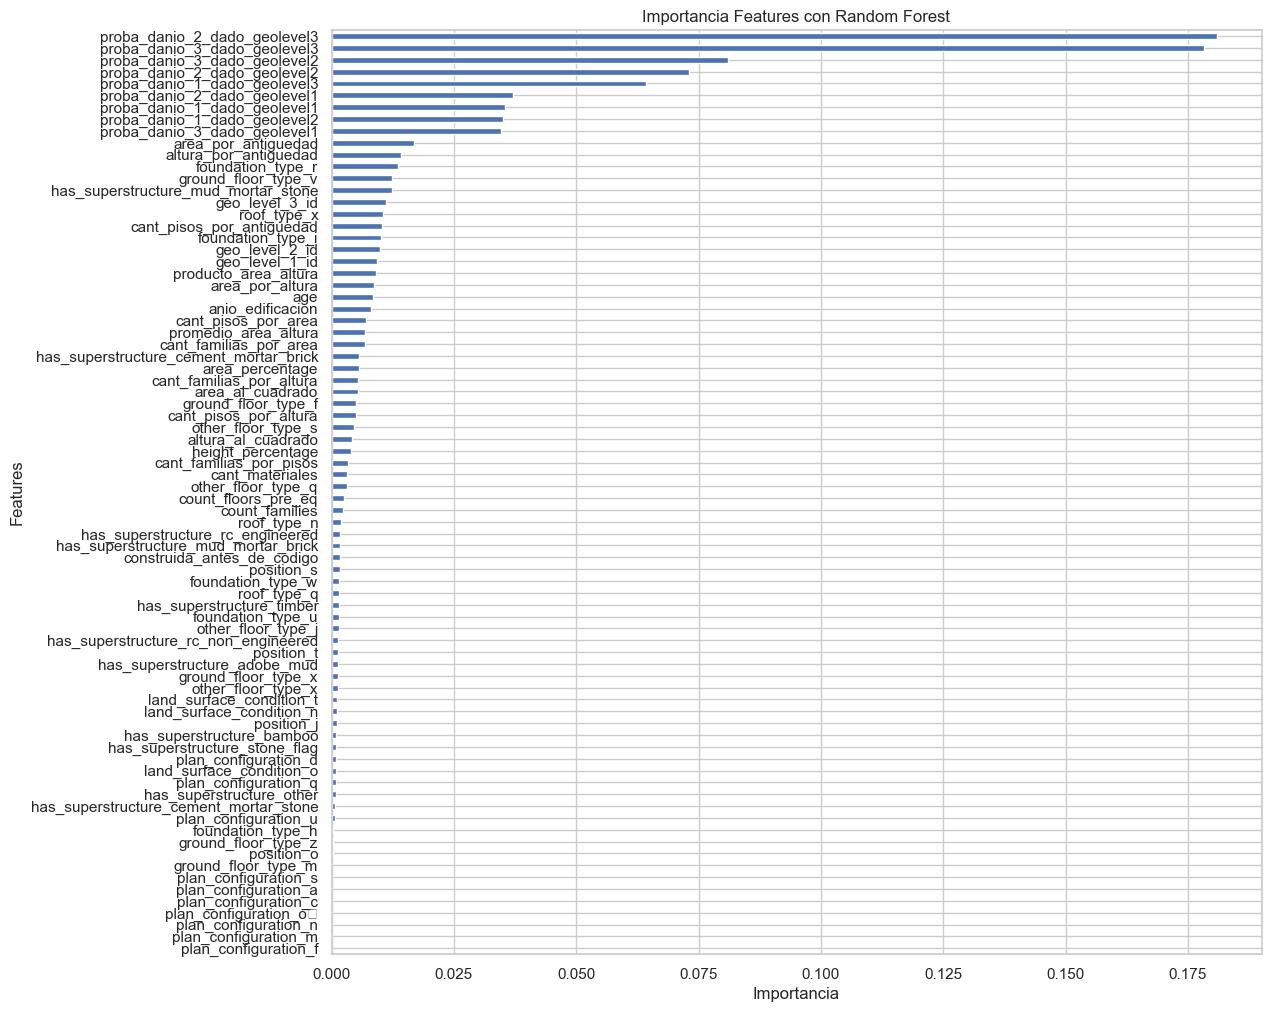

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('default')
sns.set(style="whitegrid") # seteando tipo de grid en seaborn

# Si se esta usando GridSearchCV es model.best_estimator_.feature_importances_
# Si se entrena el modelo directo es model.feature_importances_

feature_cols = X.columns.tolist()
features = pd.Series(data=model.feature_importances_, index=feature_cols, name='Feature importance')
features.sort_values(ascending=True, inplace=True)
plt.figure(figsize=(12, 12))
features.plot(kind='barh')
plt.xlabel('Importancia')
plt.ylabel('Features')
plt.title('Importancia Features con Random Forest')
plt.show()

La matriz de confusion nos muestra nuestros $tp$, $fp$, $tn$ y $fn$ en una matriz. La diagonal principal son los valores correctamente clasificados. Los otros valores indican la cantidad de puntos mal clasificados.
> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [46]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("Label correcto")
    plt.xlabel("Label predecido")
    plt.show()

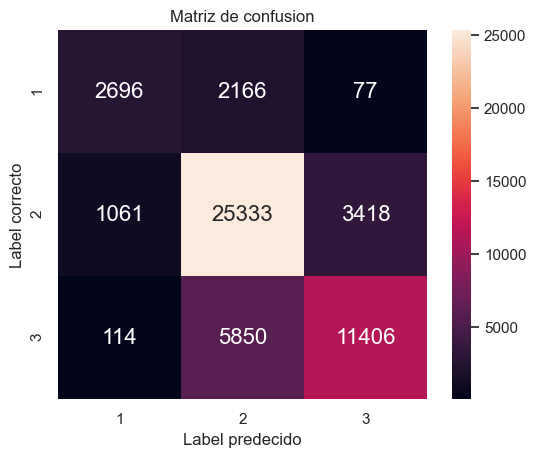

In [47]:
plot_confusion_matrix(y_test, y_pred_test)

### Prediccion del modelo

In [48]:
# Saco damage_grade de las features a remover ya que dicha feature NO esta en el set de test
features_to_remove.remove('damage_grade')
to_test = test.drop(features_to_remove, axis=1)

In [49]:
y_pred = model.predict(to_test)
y_pred

array([3, 2, 3, ..., 2, 2, 1], dtype=int64)

### Formateo de la prediccion para un submit

In [50]:
test_id = test.reset_index()['building_id']
test_id

0         300051
1          99355
2         890251
3         745817
4         421793
          ...   
86863     310028
86864     663567
86865    1049160
86866     442785
86867     501372
Name: building_id, Length: 86868, dtype: int64

In [51]:
submit = pd.concat([test_id, pd.Series(y_pred, name='damage_grade')], axis=1)
submit.set_index('building_id', inplace=True)
submit.head()

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3


In [52]:
submit.to_csv('../submits-csv/submit-RandomForest-{}.csv'.format(model_f1_micro_test))